Imports and installs

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve)
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
import warnings
warnings.filterwarnings('ignore')
import time

np.random.seed(42)
tf.random.set_seed(42)

Load data

In [38]:
df = pd.read_csv('/content/telco_customer_churn.csv')

print("Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print("\n" + "="*50 + "\n")

# Display first few rows
print("First 5 rows:")
display(df.head())

print("\n" + "="*50 + "\n")
print("Dataset Information:")
print(df.info())

print("\n" + "="*50 + "\n")
print("Basic Statistics:")
display(df.describe())

print("\n" + "="*50 + "\n")
print("Missing Values:")
missing_data = df.isnull().sum()
print(missing_data[missing_data > 0])

# Check for empty spaces (common issue in this dataset)
print("\nChecking for empty strings...")
for col in df.columns:
    if df[col].dtype == 'object':
        empty_count = (df[col] == ' ').sum() + (df[col] == '').sum()
        if empty_count > 0:
            print(f"{col}: {empty_count} empty values")

# Fix the TotalCharges column (has empty strings)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print(f"\nTotalCharges missing after conversion: {df['TotalCharges'].isnull().sum()}")

# Fill missing TotalCharges with 0 (for customers with tenure 0)
df['TotalCharges'].fillna(0, inplace=True)

# Check class distribution
print("\n" + "="*50 + "\n")
print("Class Distribution (Churn):")
churn_dist = df['Churn'].value_counts()
print(churn_dist)
print(f"\nChurn Rate: {(churn_dist['Yes']/len(df))*100:.2f}%")

Dataset loaded successfully!
Dataset shape: (7043, 21)


First 5 rows:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes




Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000




Missing Values:
Series([], dtype: int64)

Checking for empty strings...
TotalCharges: 11 empty values

TotalCharges missing after conversion: 11


Class Distribution (Churn):
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Churn Rate: 26.54%


Exploratory data analysis

Missing Values:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

TARGET DISTRIBUTION
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Percentage:
Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


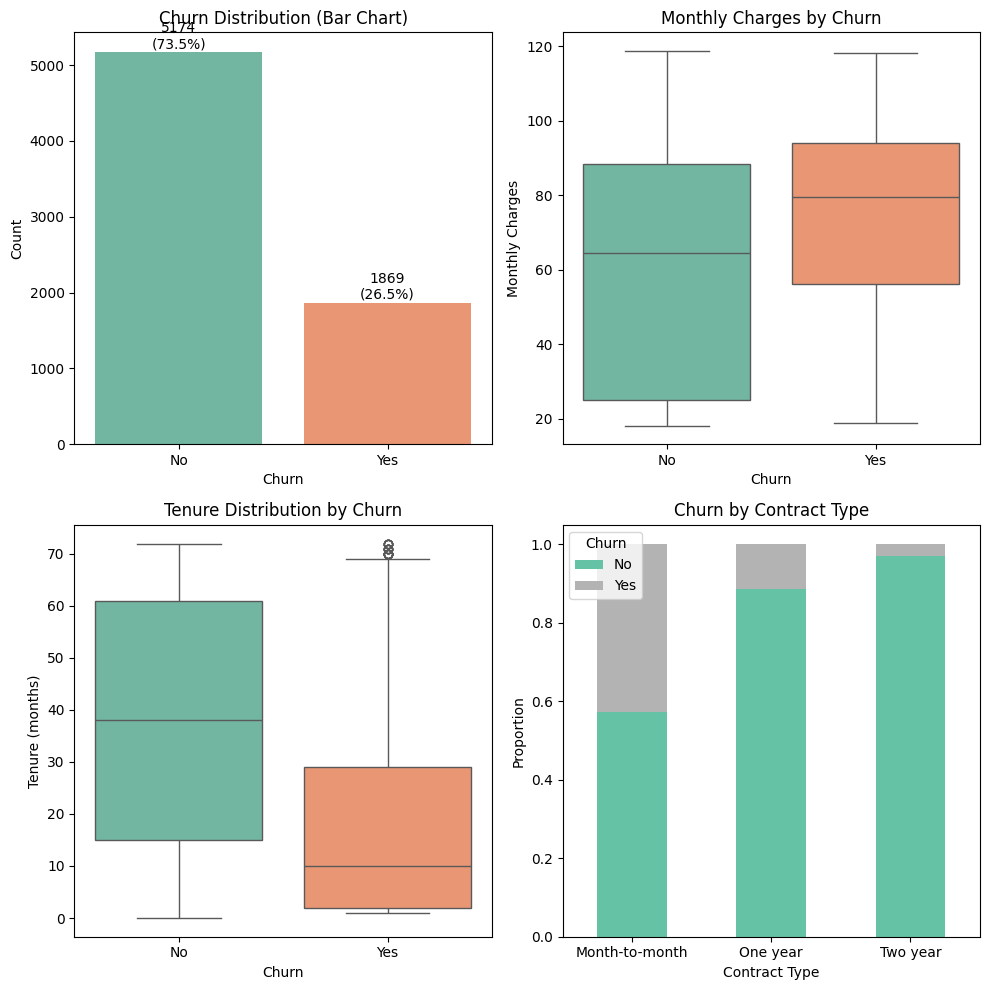


CORRELATION ANALYSIS


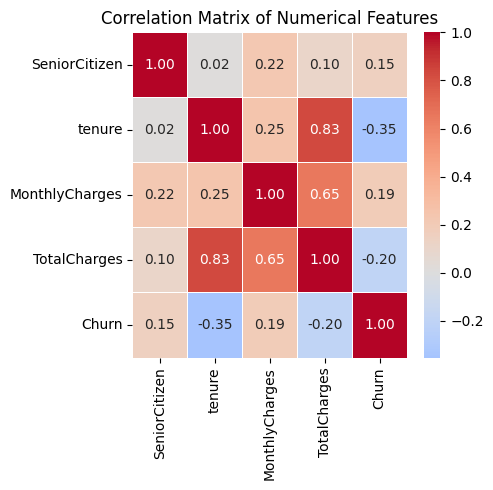

In [31]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())

# Handle TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(0, inplace=True)

# Target distribution
print("\n" + "="*50)
print("TARGET DISTRIBUTION")
print("="*50)
churn_counts = df['Churn'].value_counts()
churn_percent = df['Churn'].value_counts(normalize=True) * 100
print(churn_counts)
print(f"\nPercentage:\n{churn_percent}")

# Create figure with 2 rows, 2 columns
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# 1. Churn Distribution (Bar Chart)
sns.countplot(x='Churn', data=df, palette='Set2', ax=axes[0, 0])
axes[0, 0].set_title('Churn Distribution (Bar Chart)')
axes[0, 0].set_xlabel('Churn')
axes[0, 0].set_ylabel('Count')
for i, (count, percent) in enumerate(zip(churn_counts.values, churn_percent.values)):
    axes[0, 0].text(i, count + 50, f'{count}\n({percent:.1f}%)', ha='center')

# 2. MonthlyCharges vs Churn (Box Plot)
sns.boxplot(x='Churn', y='MonthlyCharges', data=df, ax=axes[0, 1], palette='Set2')
axes[0, 1].set_title('Monthly Charges by Churn')
axes[0, 1].set_xlabel('Churn')
axes[0, 1].set_ylabel('Monthly Charges')

# 3. Tenure vs Churn (Box Plot)
sns.boxplot(x='Churn', y='tenure', data=df, ax=axes[1, 0], palette='Set2')
axes[1, 0].set_title('Tenure Distribution by Churn')
axes[1, 0].set_xlabel('Churn')
axes[1, 0].set_ylabel('Tenure (months)')

# 4. Contract vs Churn (Stacked Bar)
contract_churn = df.groupby('Contract')['Churn'].value_counts(normalize=True).unstack()
contract_churn.plot(kind='bar', stacked=True, ax=axes[1, 1], colormap='Set2')
axes[1, 1].set_title('Churn by Contract Type')
axes[1, 1].set_xlabel('Contract Type')
axes[1, 1].set_ylabel('Proportion')
axes[1, 1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

# 5. Correlation Matrix (separate figure)
print("\n" + "="*50)
print("CORRELATION ANALYSIS")
print("="*50)

df_numeric = df.copy()
df_numeric['Churn'] = df_numeric['Churn'].map({'No': 0, 'Yes': 1})
df_numeric['SeniorCitizen'] = df_numeric['SeniorCitizen'].astype(int)
numeric_for_corr = df_numeric.select_dtypes(include=[np.number])

plt.figure(figsize=(5, 5))
sns.heatmap(numeric_for_corr.corr(), annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

Data preprocessing

In [32]:
# Prepare data
df_processed = df.drop('customerID', axis=1)
df_processed['Churn'] = df_processed['Churn'].map({'No': 0, 'Yes': 1})

# Define features
categorical_features = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
numerical_features = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

# Create preprocessing pipeline
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='first', sparse_output=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split data
X = df_processed.drop('Churn', axis=1)
y = df_processed['Churn']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Processed features: {X_train_processed.shape[1]}")

# Apply SMOTE for class imbalance
from imblearn.over_sampling import SMOTE

print("\n" + "="*50)
print("APPLYING SMOTE FOR CLASS IMBALANCE")
print("="*50)

print(f"Before SMOTE - Class distribution:")
print(f"Class 0 (No Churn): {(y_train == 0).sum()} samples")
print(f"Class 1 (Churn): {(y_train == 1).sum()} samples")
print(f"Imbalance ratio: {(y_train == 0).sum() / (y_train == 1).sum():.2f}:1")

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

print(f"\nAfter SMOTE - Class distribution:")
print(f"Class 0 (No Churn): {(y_train_resampled == 0).sum()} samples")
print(f"Class 1 (Churn): {(y_train_resampled == 1).sum()} samples")
print(f"Imbalance ratio: {(y_train_resampled == 0).sum() / (y_train_resampled == 1).sum():.2f}:1")

Training set: (5634, 19)
Test set: (1409, 19)
Processed features: 30

APPLYING SMOTE FOR CLASS IMBALANCE
Before SMOTE - Class distribution:
Class 0 (No Churn): 4139 samples
Class 1 (Churn): 1495 samples
Imbalance ratio: 2.77:1

After SMOTE - Class distribution:
Class 0 (No Churn): 4139 samples
Class 1 (Churn): 4139 samples
Imbalance ratio: 1.00:1


Neural network-based model


NEURAL NETWORK MODEL
Tuning Neural Network...
Fitting 4 folds for each of 18 candidates, totalling 72 fits

 Tuning completed
Best parameters: {'activation': 'relu', 'alpha': 0.1, 'batch_size': 64, 'early_stopping': True, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.001, 'max_iter': 300, 'validation_fraction': 0.2}

NEURAL NETWORK RESULTS
Training Accuracy:  0.7983
Test Accuracy:      0.7495
Accuracy Gap:       0.0488

Test Set Metrics:
Precision (Churn):  0.5192
Recall (Churn):     0.7594
F1 (No Churn):      0.8139
F1 (Churn):         0.6167
ROC-AUC:            0.8400


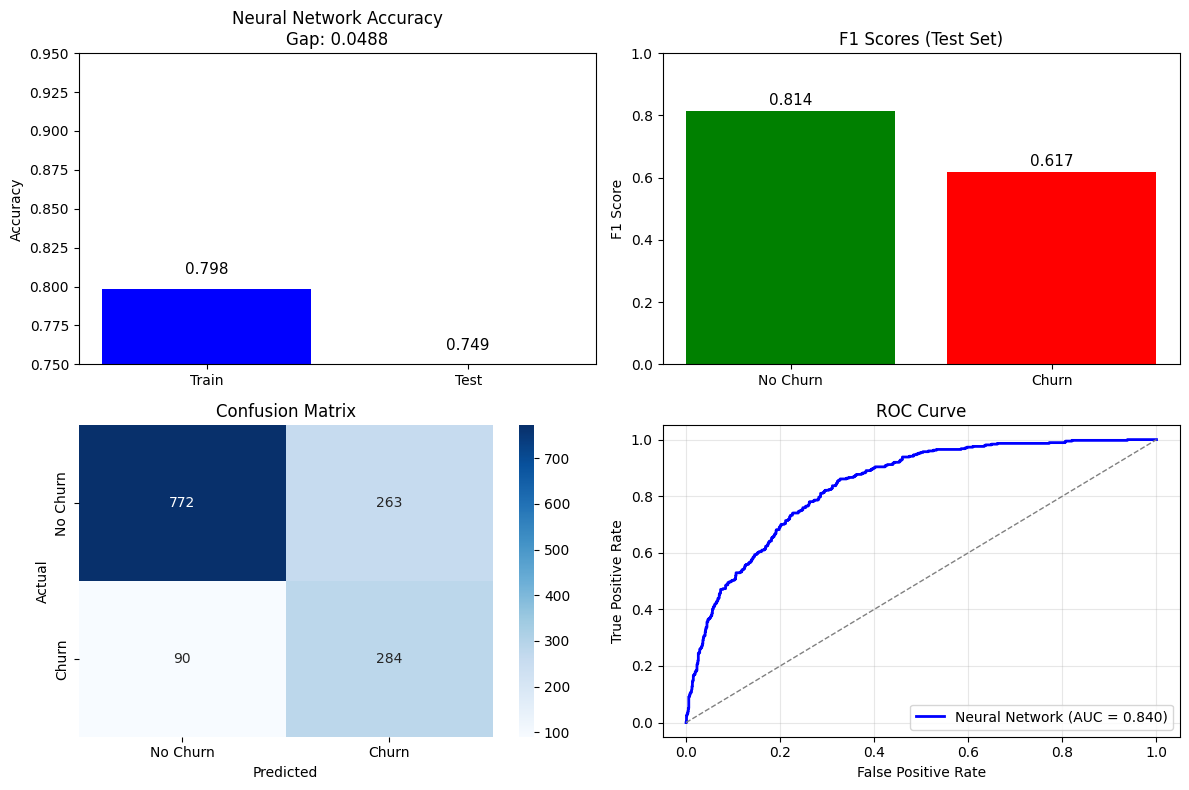


CLASSIFICATION REPORT
              precision    recall  f1-score   support

    No Churn     0.8956    0.7459    0.8139      1035
       Churn     0.5192    0.7594    0.6167       374

    accuracy                         0.7495      1409
   macro avg     0.7074    0.7526    0.7153      1409
weighted avg     0.7957    0.7495    0.7616      1409



In [33]:
print("\n" + "="*80)
print("NEURAL NETWORK MODEL")
print("="*80)

from sklearn.neural_network import MLPClassifier

# Parameter grid
mlp_param_grid = {
    'hidden_layer_sizes': [(30,), (50,), (30, 15)],
    'activation': ['relu'],
    'alpha': [0.01, 0.05, 0.1],
    'learning_rate_init': [0.001],
    'max_iter': [300, 400],
    'batch_size': [64],
    'early_stopping': [True],
    'validation_fraction': [0.2]
}

print("Tuning Neural Network...")
mlp_grid = GridSearchCV(
    MLPClassifier(random_state=42),
    mlp_param_grid,
    cv=4,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

start_time = time.time()
mlp_grid.fit(X_train_resampled, y_train_resampled)
nn_time = time.time() - start_time

# Best model from GridSearchCV
best_mlp = mlp_grid.best_estimator_

print(f"\n Tuning completed")
print(f"Best parameters: {mlp_grid.best_params_}")

# Predictions with the tuned model
y_train_pred_mlp = best_mlp.predict(X_train_resampled)
y_pred_mlp = best_mlp.predict(X_test_processed)
y_pred_mlp_prob = best_mlp.predict_proba(X_test_processed)[:, 1]

# Calculate metrics
mlp_train_acc = accuracy_score(y_train_resampled, y_train_pred_mlp)
mlp_test_acc = accuracy_score(y_test, y_pred_mlp)
accuracy_gap_mlp = mlp_train_acc - mlp_test_acc

mlp_test_precision = precision_score(y_test, y_pred_mlp)
mlp_test_recall = recall_score(y_test, y_pred_mlp)
mlp_test_f1_class0 = f1_score(y_test, y_pred_mlp, pos_label=0)
mlp_test_f1_class1 = f1_score(y_test, y_pred_mlp, pos_label=1)
mlp_test_roc_auc = roc_auc_score(y_test, y_pred_mlp_prob)

# Display results
print("\n" + "="*60)
print("NEURAL NETWORK RESULTS")
print("="*60)
print(f"Training Accuracy:  {mlp_train_acc:.4f}")
print(f"Test Accuracy:      {mlp_test_acc:.4f}")
print(f"Accuracy Gap:       {accuracy_gap_mlp:.4f}")

print(f"\nTest Set Metrics:")
print(f"Precision (Churn):  {mlp_test_precision:.4f}")
print(f"Recall (Churn):     {mlp_test_recall:.4f}")
print(f"F1 (No Churn):      {mlp_test_f1_class0:.4f}")
print(f"F1 (Churn):         {mlp_test_f1_class1:.4f}")
print(f"ROC-AUC:            {mlp_test_roc_auc:.4f}")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 1. Accuracy comparison
axes[0, 0].bar(['Train', 'Test'], [mlp_train_acc, mlp_test_acc], color=['blue', 'orange'])
axes[0, 0].set_title(f'Neural Network Accuracy\nGap: {accuracy_gap_mlp:.4f}')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_ylim([0.75, 0.95])
for i, acc in enumerate([mlp_train_acc, mlp_test_acc]):
    axes[0, 0].text(i, acc + 0.01, f'{acc:.3f}', ha='center', fontsize=11)

# 2. F1 Scores
axes[0, 1].bar(['No Churn', 'Churn'], [mlp_test_f1_class0, mlp_test_f1_class1], color=['green', 'red'])
axes[0, 1].set_title('F1 Scores (Test Set)')
axes[0, 1].set_ylabel('F1 Score')
axes[0, 1].set_ylim([0, 1])
for i, f1 in enumerate([mlp_test_f1_class0, mlp_test_f1_class1]):
    axes[0, 1].text(i, f1 + 0.02, f'{f1:.3f}', ha='center', fontsize=11)

# 3. Confusion matrix
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
axes[1, 0].set_title('Confusion Matrix')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')

# 4. ROC Curve
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_pred_mlp_prob)
axes[1, 1].plot(fpr_mlp, tpr_mlp, color='blue', lw=2,
               label=f'Neural Network (AUC = {mlp_test_roc_auc:.3f})')
axes[1, 1].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
axes[1, 1].set_title('ROC Curve')
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].legend(loc='lower right')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test, y_pred_mlp, target_names=['No Churn', 'Churn'], digits=4))

Decision Tree model


DECISION TREE MODEL
Tuning Decision Tree...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits

 Tuning completed
Best parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 0.7, 'max_leaf_nodes': 50, 'min_samples_leaf': 5, 'min_samples_split': 30}

DECISION TREE RESULTS
Training Accuracy:  0.8175
Test Accuracy:      0.7516
Accuracy Gap:       0.0659

Test Set Metrics:
Precision (Churn):  0.5248
Recall (Churn):     0.6791
F1 (No Churn):      0.8214
F1 (Churn):         0.5921
ROC-AUC:            0.8181

 Tree Details:
  Max Depth: 10
  Number of Leaves: 50
  Min Samples Split: 30
  Min Samples Leaf: 5


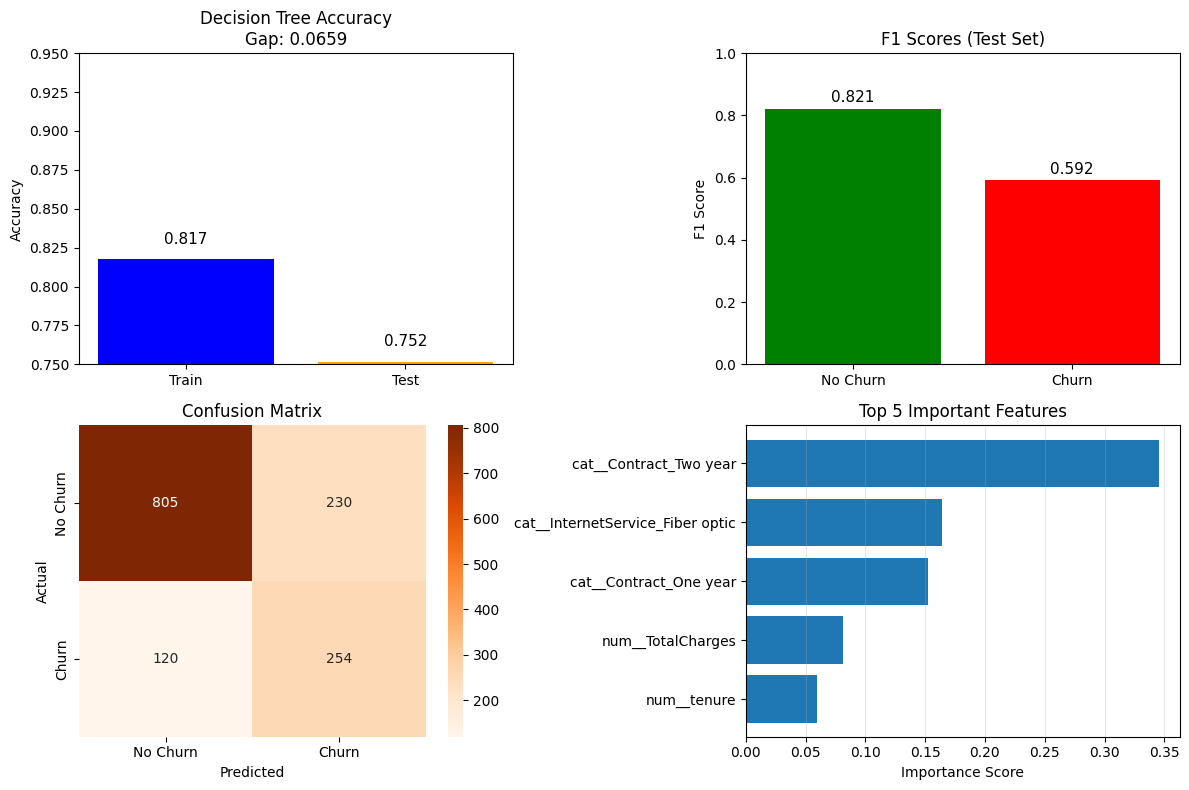

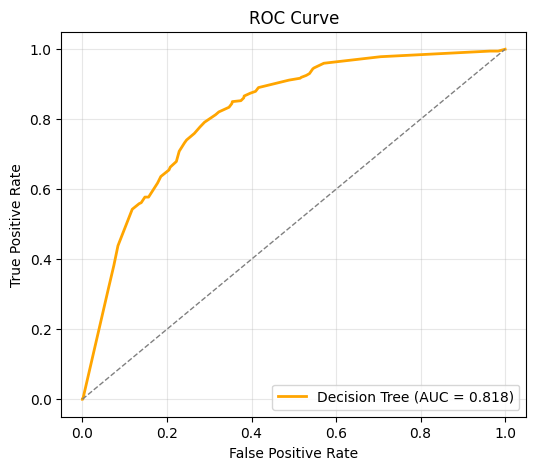


TOP 5 MOST IMPORTANT FEATURES
                         feature  importance
          cat__Contract_Two year    0.345530
cat__InternetService_Fiber optic    0.163871
          cat__Contract_One year    0.152455
               num__TotalCharges    0.081479
                     num__tenure    0.059220

CLASSIFICATION REPORT
              precision    recall  f1-score   support

    No Churn     0.8703    0.7778    0.8214      1035
       Churn     0.5248    0.6791    0.5921       374

    accuracy                         0.7516      1409
   macro avg     0.6975    0.7285    0.7068      1409
weighted avg     0.7786    0.7516    0.7605      1409



In [34]:
print("\n" + "="*80)
print("DECISION TREE MODEL")
print("="*80)

# Parameter grid
dt_param_grid = {
    'max_depth': [6, 8, 10],
    'min_samples_split': [10, 20, 30],
    'min_samples_leaf': [5, 10, 15],
    'criterion': ['gini'],
    'max_features': [0.7, 0.8, 'sqrt'],
    'max_leaf_nodes': [30, 50, 100]
}

print("Tuning Decision Tree...")
dt_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    dt_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

start_time = time.time()
dt_grid.fit(X_train_resampled, y_train_resampled)
dt_time = time.time() - start_time

# Best model from GridSearchCV
best_dt = dt_grid.best_estimator_

print(f"\n Tuning completed")
print(f"Best parameters: {dt_grid.best_params_}")

# Predictions with the tuned model
y_train_pred_dt = best_dt.predict(X_train_resampled)
y_pred_dt = best_dt.predict(X_test_processed)
y_pred_dt_prob = best_dt.predict_proba(X_test_processed)[:, 1]

# Calculate metrics
dt_train_acc = accuracy_score(y_train_resampled, y_train_pred_dt)
dt_test_acc = accuracy_score(y_test, y_pred_dt)
accuracy_gap_dt = dt_train_acc - dt_test_acc

dt_test_precision = precision_score(y_test, y_pred_dt)
dt_test_recall = recall_score(y_test, y_pred_dt)
dt_test_f1_class0 = f1_score(y_test, y_pred_dt, pos_label=0)
dt_test_f1_class1 = f1_score(y_test, y_pred_dt, pos_label=1)
dt_test_roc_auc = roc_auc_score(y_test, y_pred_dt_prob)

# Display results
print("\n" + "="*60)
print("DECISION TREE RESULTS")
print("="*60)
print(f"Training Accuracy:  {dt_train_acc:.4f}")
print(f"Test Accuracy:      {dt_test_acc:.4f}")
print(f"Accuracy Gap:       {accuracy_gap_dt:.4f}")

print(f"\nTest Set Metrics:")
print(f"Precision (Churn):  {dt_test_precision:.4f}")
print(f"Recall (Churn):     {dt_test_recall:.4f}")
print(f"F1 (No Churn):      {dt_test_f1_class0:.4f}")
print(f"F1 (Churn):         {dt_test_f1_class1:.4f}")
print(f"ROC-AUC:            {dt_test_roc_auc:.4f}")

print(f"\n Tree Details:")
print(f"  Max Depth: {best_dt.get_depth()}")
print(f"  Number of Leaves: {best_dt.get_n_leaves()}")
print(f"  Min Samples Split: {best_dt.min_samples_split}")
print(f"  Min Samples Leaf: {best_dt.min_samples_leaf}")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 1. Accuracy comparison
axes[0, 0].bar(['Train', 'Test'], [dt_train_acc, dt_test_acc], color=['blue', 'orange'])
axes[0, 0].set_title(f'Decision Tree Accuracy\nGap: {accuracy_gap_dt:.4f}')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_ylim([0.75, 0.95])
for i, acc in enumerate([dt_train_acc, dt_test_acc]):
    axes[0, 0].text(i, acc + 0.01, f'{acc:.3f}', ha='center', fontsize=11)

# 2. F1 Scores
axes[0, 1].bar(['No Churn', 'Churn'], [dt_test_f1_class0, dt_test_f1_class1], color=['green', 'red'])
axes[0, 1].set_title('F1 Scores (Test Set)')
axes[0, 1].set_ylabel('F1 Score')
axes[0, 1].set_ylim([0, 1])
for i, f1 in enumerate([dt_test_f1_class0, dt_test_f1_class1]):
    axes[0, 1].text(i, f1 + 0.02, f'{f1:.3f}', ha='center', fontsize=11)

# 3. Confusion matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Oranges', ax=axes[1, 0],
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
axes[1, 0].set_title('Confusion Matrix')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')

# 4. Feature Importance
feature_names = preprocessor.get_feature_names_out()
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': best_dt.feature_importances_
}).sort_values('importance', ascending=False)

top_5 = feature_importance.head(5)
axes[1, 1].barh(range(len(top_5)), top_5['importance'])
axes[1, 1].set_yticks(range(len(top_5)))
axes[1, 1].set_yticklabels(top_5['feature'])
axes[1, 1].invert_yaxis()
axes[1, 1].set_title('Top 5 Important Features')
axes[1, 1].set_xlabel('Importance Score')
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# 5. ROC Curve
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_dt_prob)
dt_roc_auc = roc_auc_score(y_test, y_pred_dt_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr_dt, tpr_dt, color='orange', lw=2, label=f'Decision Tree (AUC = {dt_roc_auc:.3f})')
plt.plot([0,1], [0,1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

print("\n" + "="*60)
print("TOP 5 MOST IMPORTANT FEATURES")
print("="*60)
print(feature_importance.head(5).to_string(index=False))

print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test, y_pred_dt, target_names=['No Churn', 'Churn'], digits=4))

Evaluation & Comparison


MODEL COMPARISON

 PERFORMANCE COMPARISON
----------------------------------------------------------------------
           Metric Neural Network Decision Tree
 Accuracy (Train)         0.7983        0.8175
  Accuracy (Test)         0.7495        0.7516
     Accuracy Gap         0.0488        0.0659
Precision (Churn)         0.5192        0.5248
   Recall (Churn)         0.7594        0.6791
    F1 (No Churn)         0.8139        0.8214
       F1 (Churn)         0.6167        0.5921
          ROC-AUC         0.8400        0.8181


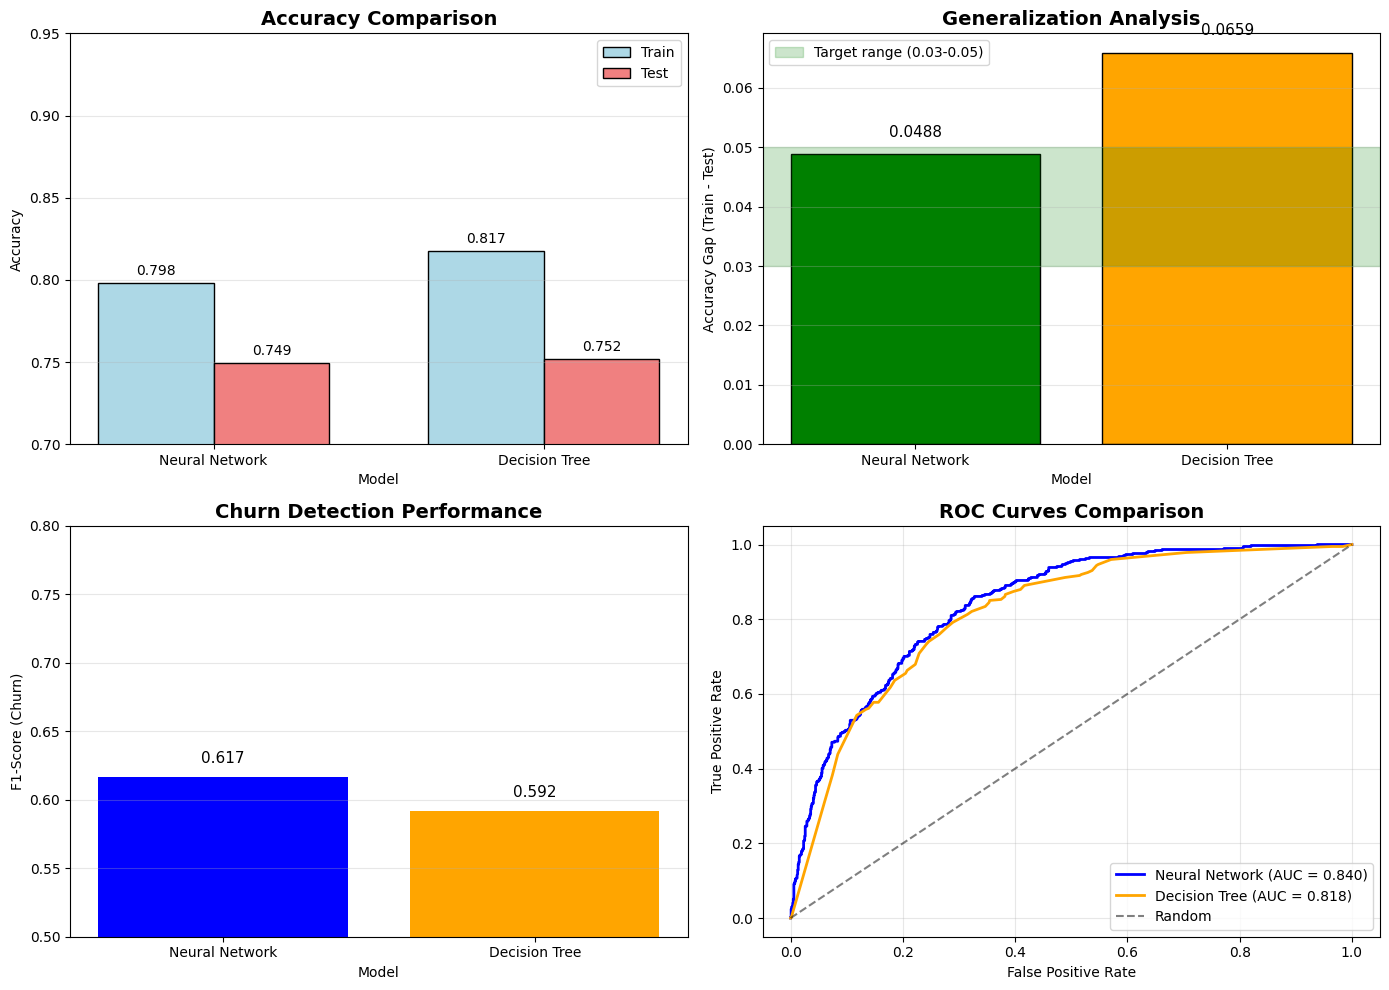

In [35]:
print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)

# First, calculate ROC curves for both models (needed for visualization)
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_pred_mlp_prob)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_dt_prob)

# Comparison table
print("\n PERFORMANCE COMPARISON")
print("-"*70)

comparison_data = {
    'Metric': ['Accuracy (Train)', 'Accuracy (Test)', 'Accuracy Gap',
               'Precision (Churn)', 'Recall (Churn)',
               'F1 (No Churn)', 'F1 (Churn)', 'ROC-AUC'],
    'Neural Network': [
        f"{mlp_train_acc:.4f}",
        f"{mlp_test_acc:.4f}",
        f"{accuracy_gap_mlp:.4f}",
        f"{mlp_test_precision:.4f}",
        f"{mlp_test_recall:.4f}",
        f"{mlp_test_f1_class0:.4f}",
        f"{mlp_test_f1_class1:.4f}",
        f"{mlp_test_roc_auc:.4f}"
    ],
    'Decision Tree': [
        f"{dt_train_acc:.4f}",
        f"{dt_test_acc:.4f}",
        f"{accuracy_gap_dt:.4f}",
        f"{dt_test_precision:.4f}",
        f"{dt_test_recall:.4f}",
        f"{dt_test_f1_class0:.4f}",
        f"{dt_test_f1_class1:.4f}",
        f"{dt_test_roc_auc:.4f}"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Visual Comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Accuracy Comparison
models = ['Neural Network', 'Decision Tree']
test_acc = [mlp_test_acc, dt_test_acc]
train_acc = [mlp_train_acc, dt_train_acc]

x = np.arange(len(models))
width = 0.35

axes[0, 0].bar(x - width/2, train_acc, width, label='Train', color='lightblue', edgecolor='black')
axes[0, 0].bar(x + width/2, test_acc, width, label='Test', color='lightcoral', edgecolor='black')
axes[0, 0].set_xlabel('Model')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(models)
axes[0, 0].legend()
axes[0, 0].set_ylim([0.7, 0.95])
axes[0, 0].grid(alpha=0.3, axis='y')

for i, (train, test) in enumerate(zip(train_acc, test_acc)):
    axes[0, 0].text(i - width/2, train + 0.005, f'{train:.3f}', ha='center', fontsize=10)
    axes[0, 0].text(i + width/2, test + 0.005, f'{test:.3f}', ha='center', fontsize=10)

# 2. Accuracy Gap Comparison
accuracy_gaps = [accuracy_gap_mlp, accuracy_gap_dt]
colors = ['green' if 0.03 <= gap <= 0.05 else 'orange' if gap <= 0.07 else 'red' for gap in accuracy_gaps]

axes[0, 1].bar(models, accuracy_gaps, color=colors, edgecolor='black')
axes[0, 1].axhspan(0.03, 0.05, alpha=0.2, color='green', label='Target range (0.03-0.05)')
axes[0, 1].set_xlabel('Model')
axes[0, 1].set_ylabel('Accuracy Gap (Train - Test)')
axes[0, 1].set_title('Generalization Analysis', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3, axis='y')

for i, gap in enumerate(accuracy_gaps):
    axes[0, 1].text(i, gap + 0.003, f'{gap:.4f}', ha='center', fontsize=11)

# 3. F1-Score Comparison for Churn
axes[1, 0].bar(models, [mlp_test_f1_class1, dt_test_f1_class1], color=['blue', 'orange'])
axes[1, 0].set_xlabel('Model')
axes[1, 0].set_ylabel('F1-Score (Churn)')
axes[1, 0].set_title('Churn Detection Performance', fontsize=14, fontweight='bold')
axes[1, 0].set_ylim([0.5, 0.8])
axes[1, 0].grid(alpha=0.3, axis='y')

for i, f1 in enumerate([mlp_test_f1_class1, dt_test_f1_class1]):
    axes[1, 0].text(i, f1 + 0.01, f'{f1:.3f}', ha='center', fontsize=11)

# 4. ROC Curves Comparison
axes[1, 1].plot(fpr_mlp, tpr_mlp, label=f'Neural Network (AUC = {mlp_test_roc_auc:.3f})',
               linewidth=2, color='blue')
axes[1, 1].plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {dt_test_roc_auc:.3f})',
               linewidth=2, color='orange')
axes[1, 1].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].set_title('ROC Curves Comparison', fontsize=14, fontweight='bold')
axes[1, 1].legend(loc='lower right')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()